In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [4]:
###调整数据类型，帮助我们减少数据在内存中占用的空间

def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum()
    print('调整之前占用内存{}'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)    
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum()
    print('调整后占用内存{}'.format(end_mem))
    return df

In [6]:
sample_feature = reduce_mem_usage(pd.read_csv('data_for_tree.csv'))

调整之前占用内存55730488
调整后占用内存55730488


In [7]:
data =pd.read_csv('data_for_tree.csv')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199037 entries, 0 to 199036
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   SaleID               199037 non-null  int64  
 1   name                 199037 non-null  int64  
 2   model                199036 non-null  float64
 3   brand                199037 non-null  int64  
 4   bodyType             193039 non-null  float64
 5   fuelType             187481 non-null  float64
 6   gearbox              191115 non-null  float64
 7   power                199037 non-null  int64  
 8   kilometer            199037 non-null  float64
 9   notRepairedDamage    166748 non-null  float64
 10  price                149037 non-null  float64
 11  v_0                  199037 non-null  float64
 12  v_1                  199037 non-null  float64
 13  v_2                  199037 non-null  float64
 14  v_3                  199037 non-null  float64
 15  v_4              

In [9]:
sample_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199037 entries, 0 to 199036
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   SaleID               199037 non-null  int32  
 1   name                 199037 non-null  int32  
 2   model                199036 non-null  float16
 3   brand                199037 non-null  int8   
 4   bodyType             193039 non-null  float16
 5   fuelType             187481 non-null  float16
 6   gearbox              191115 non-null  float16
 7   power                199037 non-null  int16  
 8   kilometer            199037 non-null  float16
 9   notRepairedDamage    166748 non-null  float16
 10  price                149037 non-null  float32
 11  v_0                  199037 non-null  float16
 12  v_1                  199037 non-null  float16
 13  v_2                  199037 non-null  float16
 14  v_3                  199037 non-null  float16
 15  v_4              

In [10]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(normalize=True)

# model = model.fit

In [11]:
##线性回归 五折交叉验证 模拟真实业务情况

continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model','SaleID', 'name']]

sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)

sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)

train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]

train_y = train['price']

In [12]:
model = model.fit(train_X, train_y)

In [13]:
import matplotlib.pyplot as plt

subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

The predicted price is obvious different from true price


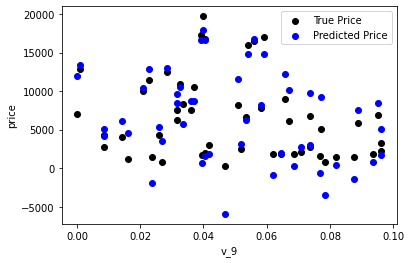

In [14]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

It is clear to see the price shows a typical exponential distribution


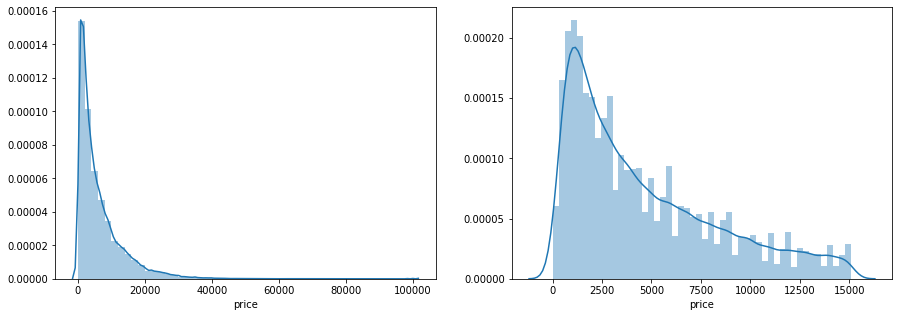

In [15]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

In [16]:
###我们对price(预测值)进行log变换，更符合正态分布
train_y_ln = np.log(train_y + 1)

The transformed price seems like normal distribution


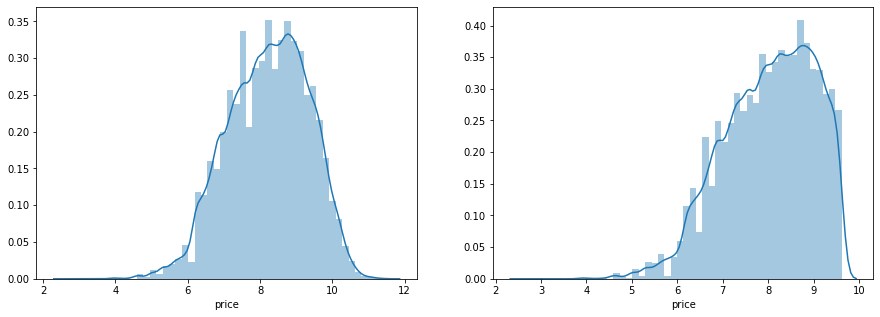

In [17]:
import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [18]:
model = model.fit(train_X, train_y_ln)

The predicted price seems normal after np.log transforming


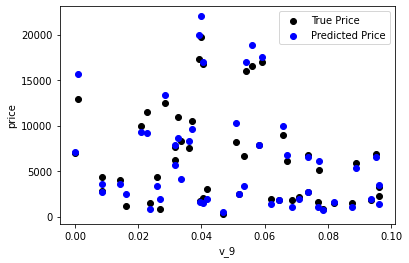

In [19]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

In [20]:
###交叉验证
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

def log_transfer(func):
    def warpper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return warpper

scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv=5, scoring=make_scorer(log_transfer(mean_absolute_error)))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


In [22]:
print('AVG:{}'.format(np.mean(scores)))

AVG:1.3188858032226562


In [23]:
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


In [24]:
print('AVG:{}'.format(np.mean(scores)))

AVG:0.1948619306087494


In [25]:
scores = pd.DataFrame(scores.reshape(1, -1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.193746,0.19544,0.195641,0.192899,0.196584


In [26]:
##模拟真实业务情况
##通过训练17年以前的数据来预测18年的数据
import datetime
sample_feature = sample_feature.reset_index(drop=True)

split_point = len(sample_feature) // 5 * 4

In [27]:
train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]

train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]

val_y_ln = np.log(val['price'] + 1)

In [28]:
model = model.fit(train_X, train_y_ln)

In [29]:
mean_absolute_error(val_y_ln, model.predict(val_X))

0.19660032

In [30]:
##绘制学习率曲线和验证曲线
from sklearn.model_selection import learning_curve, validation_curve

In [31]:
##多种模型比较
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
models = [
         LogisticRegression(),
         DecisionTreeRegressor(),
         Lasso(),
         Ridge(),
         SVC(),
#          RandomForestRegressor(n_estimators=3000, max_depth=10),
#          GradientBoostingRegressor(n_estimators=3000, max_depth=10),
         LinearRegression()]

result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln.astype('int'), verbose=0, cv=5, scoring=make_scorer(mean_absolute_error))
    
    result[model_name] = scores
    
    print(model_name + ' is finished')

LogisticRegression is finished
DecisionTreeRegressor is finished
Lasso is finished
Ridge is finished


In [42]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1,6)]
result

,LogisticRegression,DecisionTreeRegressor,Lasso,Ridge,SVC,LinearRegression
cv1,NaN,0.195576,0.374591,0.196862,NaN,0.374276
cv2,NaN,0.194010,0.373048,0.198569,NaN,0.373174
cv3,NaN,0.193957,0.375789,0.198904,NaN,0.375995
cv4,NaN,0.198699,0.370437,0.197027,NaN,0.370683
cv5,NaN,0.193871,0.369841,0.195950,NaN,0.370129


In [ ]:
LR = SVC()
m_model = LR.fit(train_X, train_y_ln.astype('int'))

In [ ]:
train_y_ln

In [109]:
test_data = data[data['train'] == 0]

In [44]:
## LGB的参数集合：

objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']

num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []

In [47]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': range(10, 110, 10), 'max_depth': max_depth}

model = RandomForestRegressor(n_jobs=-1)

clf = GridSearchCV(model, params, cv=5)

clf = clf.fit(train_X, train_y_ln)

print(clf.best_params_)

{'max_depth': 20, 'n_estimators': 90}


In [49]:
test_data = data[data['train'] == 0]

In [52]:
test_data.price[:5]

149037   NaN
149038   NaN
149039   NaN
149040   NaN
149041   NaN
Name: price, dtype: float64

In [53]:
test_data.drop(['price'], axis=1, inplace=True)

In [55]:
RFR = RandomForestRegressor(n_estimators=90, n_jobs=-1, max_depth=20)

In [56]:

model = RFR.fit(train_X, train_y_ln)

In [110]:
test_data.isnull().sum()

SaleID                     0
name                       0
model                      0
brand                      0
bodyType                1504
fuelType                2924
gearbox                 1968
power                      0
kilometer                  0
notRepairedDamage       8069
price                  50000
v_0                        0
v_1                        0
v_2                        0
v_3                        0
v_4                        0
v_5                        0
v_6                        0
v_7                        0
v_8                        0
v_9                        0
v_10                       0
v_11                       0
v_12                       0
v_13                       0
v_14                       0
train                      0
usedTime                3736
brand_amount               0
brand_price_max            0
brand_price_min            0
brand_price_sum            0
brand_price_std            0
brand_price_average        0
power_bin     

In [59]:
test_data = test_data.dropna()

In [61]:
test_data.isnull().sum()

SaleID                 0
name                   0
model                  0
brand                  0
bodyType               0
fuelType               0
gearbox                0
power                  0
kilometer              0
notRepairedDamage      0
v_0                    0
v_1                    0
v_2                    0
v_3                    0
v_4                    0
v_5                    0
v_6                    0
v_7                    0
v_8                    0
v_9                    0
v_10                   0
v_11                   0
v_12                   0
v_13                   0
v_14                   0
train                  0
usedTime               0
brand_amount           0
brand_price_max        0
brand_price_min        0
brand_price_sum        0
brand_price_std        0
brand_price_average    0
power_bin              0
dtype: int64

In [65]:
len(train_X.columns)

30

In [66]:
len(test_data.columns)

34

In [67]:
train_X.columns

Index(['bodyType', 'fuelType', 'gearbox', 'power', 'kilometer',
       'notRepairedDamage', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'train',
       'usedTime', 'brand_amount', 'brand_price_max', 'brand_price_min',
       'brand_price_sum', 'brand_price_std', 'brand_price_average',
       'power_bin'],
      dtype='object')

In [68]:
test_data.columns

Index(['SaleID', 'name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox',
       'power', 'kilometer', 'notRepairedDamage', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14', 'train', 'usedTime', 'brand_amount', 'brand_price_max',
       'brand_price_min', 'brand_price_sum', 'brand_price_std',
       'brand_price_average', 'power_bin'],
      dtype='object')

In [117]:
test_data_pred = test_data.drop(['SaleID', 'name', 'model', 'brand'], axis=1)

In [120]:
test_data_pred.drop(['price'], axis=1, inplace=True)
test_pred = model.predict(test_data_pred)

In [121]:
test_pred.min()

3.5576100746790567

In [73]:
test_pred[test_pred <10] = 10

In [126]:
sub = pd.DataFrame()
sub['SaleID'] = test_data.SaleID
sub['price'] = test_pred
sub['price'] = sub.price.astype('int')
sub.to_csv('./result.csv', index=False)

In [75]:
test_pred

array([10., 10., 10., ..., 10., 10., 10.])

In [122]:
test_pred = np.power(np.e, test_pred)

In [123]:
test_pred.max()

76545.88304907498

In [85]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36334 entries, 149037 to 199035
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SaleID  36334 non-null  int64  
 1   price   36334 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 851.6 KB


In [106]:
# sub['price'] = sub.price.astype('int')
sub.to_csv('./used_car_submit.csv', index=False)

In [89]:
sub.price.min()

37

In [90]:
sub

,SaleID,price
149037,200000,1268
149038,200001,1774
149040,200003,1016
149043,200006,361
149044,200007,3352
...,...,...
199030,249993,1497
199031,249994,8499
199033,249996,18497
199034,249997,5411


In [95]:
test = pd.read_csv('tianchi/used_car_sample_submit.csv', sep=',')

In [96]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   SaleID  50000 non-null  int64
 1   price   50000 non-null  int64
dtypes: int64(2)
memory usage: 781.4 KB


In [97]:
test.head()

,SaleID,price
0,150000,0
1,150001,0
2,150002,0
3,150003,0
4,150004,0


In [98]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36334 entries, 149037 to 199035
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   SaleID  36334 non-null  int64
 1   price   36334 non-null  int64
dtypes: int64(2)
memory usage: 851.6 KB


In [99]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36334 entries, 149037 to 199035
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SaleID               36334 non-null  int64  
 1   name                 36334 non-null  int64  
 2   model                36334 non-null  float64
 3   brand                36334 non-null  int64  
 4   bodyType             36334 non-null  float64
 5   fuelType             36334 non-null  float64
 6   gearbox              36334 non-null  float64
 7   power                36334 non-null  int64  
 8   kilometer            36334 non-null  float64
 9   notRepairedDamage    36334 non-null  float64
 10  v_0                  36334 non-null  float64
 11  v_1                  36334 non-null  float64
 12  v_2                  36334 non-null  float64
 13  v_3                  36334 non-null  float64
 14  v_4                  36334 non-null  float64
 15  v_5                  36334 non

In [103]:
sub.reset_index(drop=True, inplace=True)

In [105]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36334 entries, 0 to 36333
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   SaleID  36334 non-null  int64
 1   price   36334 non-null  int64
dtypes: int64(2)
memory usage: 567.8 KB


In [107]:
# sub['price'] = sub.price.astype('int')
sub.to_csv('./used_car_submit.csv', index=0)

In [112]:
test_data = test_data.fillna(-1)
test_data.reset_index(inplace=True)

In [115]:
test_data.head()

,SaleID,name,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,...,v_14,train,usedTime,brand_amount,brand_price_max,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,power_bin
0,200000,133777,67.0,0,1.0,0.0,0.0,101,15.0,0.0,...,0.803322,0,5790.0,31429.0,68500.0,13.0,173719698.0,6261.371627,5527.19,10.0
1,200001,61206,19.0,6,2.0,0.0,0.0,73,6.0,0.0,...,-0.200542,0,7698.0,10193.0,35990.0,13.0,36457518.0,4562.233331,3576.37,7.0
2,200002,67829,5.0,5,4.0,0.0,0.0,120,5.0,-1.0,...,1.027173,0,2468.0,4662.0,31500.0,20.0,15414322.0,3344.689763,3305.67,11.0
3,200003,8892,22.0,9,1.0,0.0,0.0,58,15.0,0.0,...,0.461610,0,5035.0,7299.0,68530.0,50.0,17805271.0,2975.342884,2439.08,5.0
4,200004,76998,46.0,6,0.0,-1.0,0.0,116,15.0,0.0,...,0.451014,0,4754.0,10193.0,35990.0,13.0,36457518.0,4562.233331,3576.37,11.0


In [114]:
test_data.drop(['index'], axis=1, inplace=True)

In [116]:
test_data.isnull().sum()

SaleID                 0
name                   0
model                  0
brand                  0
bodyType               0
fuelType               0
gearbox                0
power                  0
kilometer              0
notRepairedDamage      0
price                  0
v_0                    0
v_1                    0
v_2                    0
v_3                    0
v_4                    0
v_5                    0
v_6                    0
v_7                    0
v_8                    0
v_9                    0
v_10                   0
v_11                   0
v_12                   0
v_13                   0
v_14                   0
train                  0
usedTime               0
brand_amount           0
brand_price_max        0
brand_price_min        0
brand_price_sum        0
brand_price_std        0
brand_price_average    0
power_bin              0
dtype: int64

TypeError: type numpy.ndarray doesn't define __round__ method